# VAE Autoencoder

#### By [Natalí de Santi](https://natalidesanti.github.io), email: natalidesanti@gmail.com

In this notebook we will see an **image denoising** technique produced by a **VAE autoencoder**.

## 0) Summary

* Image denoising using autoencoders
* Variation Autoencoders
* Libraries
* Data
* Building the Autoencoder
* Training the model
* Testing the model
* Generating new digits

## 1) Image denoising using autoencoders

`Autoencoding` is a data compression algorithm where we have the **compression** and the **decompression** functions that are: 

_data-specific_, _lossy_, and _learned automatically from examples_.

That is the reason why that, differently from the _traditional methods_ we have seen before, this new category of _image denoising methods_
are purely **data-driven**, what means there is no need to phocus on a specific kind of noise.

A **autoencoder** can be a __deep Learning algorithm__ which takes an _input image_, assign _importance_ (learnable weight, biases and 
retains spatial relationships in the data into each one of theirs layers) to various aspects/parts in the image and is able to 
differentiate/reconstruct the same.

The general idea behind this kind of code can be visualized here:

![General autoencoder](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png)
###### Figure: Example of a general autoencoder

Then, the **autoencoder** compreehends an _encoder_ and a _decoder_. 

The **encoder** does the _encoding process_, i.e., transforms the image into a _compressed representation_ at the same time that starts the noisy reduction. 

Then, the _compressed representation_ goes to **decoder** that performs the _decoder process_, restoring the image to its true and recognizable shape. 

The encoder and decoder are usually chosen as _parametric function_, here represented by **neural networks**, and the _parameters_ of the encoding/decoding functions are optimized to minimize the **loss function**, which is a measure of the difference between the _denoised image_ and the _true_ one.

At the end of the process, we remove almost all noise in the image.

## 2) Variational Autoencoders

**Variational Autoencoders** (VAE) is a type of autoencoder with **added constraints** on the _encoded representations being learned_. 

More precisely, it is an autoencoder that **learns a latent variable model** for its _input data_. 

So instead of letting the neural network learn an arbitrary function, it is _learning the parameters of a probability distribution modeling your data_. 

If we sample points from this distribution, we can generate new input data samples: a VAE is a **generative model**.

In a VAE, an **encoder network** _turns_ the input samples $x$ into two parameters in a **latent space**, which can be denoted as `z_mean` and `z_log_sigma`. 

Then, similar $z$ points are _randomly sampled_ from the _latent normal distribution_ that is assumed to **generate the data**:
\begin{equation}
z = z\_mean + exp(z\_log\_sigma) * epsilon,
\end{equation}
where `epsilon` is a random normal tensor. 

Finally, a **decoder network** _maps_ these latent space points _back to the original input data_.

The parameters of the model are trained via _two loss functions_: 
* A reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders)
* KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term.

It is important to note that because of the generative essence of this model, the model is really **data-hungry**, needing _lots of data_ to explore all the options of the latent space.

Due to this reason I will show how to use a VAE to remove noise from one class of digits!

## 3) Libraries

Once again, the libraries are subject to your installation (see notebook of image denoising).

Here, we will implement the **CNNautoencoder** using `keras`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Reshape

#To solve the problem with tensorflow version!
import tensorflow._api.v2.compat.v1 as tf

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## 4) Data

As detailed in the first notebook, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

### Importing data

In [41]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [42]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

Let's select only handwritten digits of the number $2$:

In [43]:
x_train = x_train[np.where(y_train == 2)]
y_train = y_train[np.where(y_train == 2)]

x_test = x_test[np.where(y_test == 2)]
y_test = y_test[np.where(y_test == 2)]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5958, 28, 28), (5958,), (1032, 28, 28), (1032,))

In [9]:
dimension = x_train.shape[1]
dimension

28

### Pre-processing data

We are going to normalize the images between 0 and 1 and to reshape them.

In [10]:
norm_factor = 255.

x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor

x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

x_train.shape, x_test.shape

((5958, 28, 28, 1), (1032, 28, 28, 1))

Here, we need to noisy the images, then, we apply a Gaussian noisy matrix and clip the images between 0 and 1.

In [11]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images.

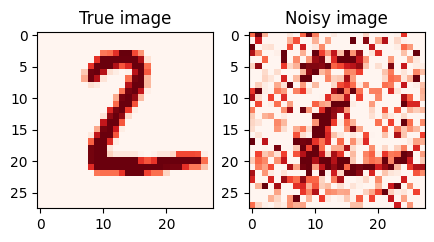

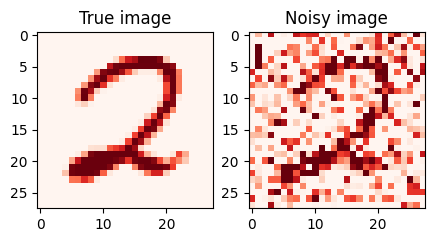

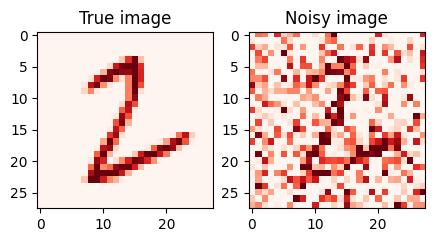

In [12]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## 5) Building the Autoencoder

In [13]:
original_dim = 784
latent_dim = 16
epochs = 40
epsilon_std = 0.5
noise_factor = 0.55
validation_split = 0.2

### Encoder

In [14]:
x_noise = Input(shape = (28, 28, 1))
x = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(x_noise)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

We can use these parameters to **sample** new similar points from the _latent space_:

In [15]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], 
                                       latent_dim), mean = 0.,
                              stddev = epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [16]:
z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])
encoder = Model(x_noise, [z_mean, z_log_var, z], name = 'encoder')#

In [44]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 16)           160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 32)           4640      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                         

### Decoder

In [17]:
latent_inputs = Input(shape = (latent_dim,), name = 'z_sampling')
x = Conv2DTranspose(32, (1, 1), padding = 'valid', activation = 'relu')(Reshape([1, 1, latent_dim])(latent_inputs))
x = Conv2DTranspose(16, (3, 3), padding = 'valid', activation = 'relu')(x)
x = Conv2DTranspose(16, (3, 3), padding = 'valid', activation = 'relu')(x)
x = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same',activation='relu')(x)
x = Conv2DTranspose(32, (3, 3), padding = 'valid', activation = 'relu')(x)
x = Conv2DTranspose(16, (3, 3), strides = (2, 2), padding = 'same',activation='relu')(x)
x = Conv2DTranspose(16, (3, 3), padding = 'valid', activation = 'relu')(x)
x_out = Conv2DTranspose(1, (3, 3), padding = 'valid', activation = 'sigmoid')(x)
decoder = Model(latent_inputs, x_out, name = 'decoder')

In [19]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 16)]              0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 1, 1, 32)          544       
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 3, 3, 16)          4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 5, 5, 16)          2320      
 Transpose)                                                      
                                                           

Notice that, for the VAE I have not used a symmetric architecture, as I have done in the **CNNautoencoder**.

### Autoencoder

Notice that we have instantiated the **encoder**, **decoder** and now we will instantiate the **autoencoder**:

In [20]:
x_out = decoder(encoder(x_noise)[2])
vae = Model(x_noise, x_out)

We can visualize the **autoencoder**:

In [21]:
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 16),              123680    
                              (None, 16),                        
                              (None, 16)]                        
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28465     
                                                                 
Total params: 152145 (594.32 KB)
Trainable params: 152145 (594.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6) Training the model

Before starting training, we have to configure our model to use a **per-pixel** `binary crossentropy` _loss_, and the `Adam` _optimizer_:

In [22]:
# Compute VAE loss
def VAE_loss(x_origin, x_out):
    x_origin = K.flatten(x_origin)
    x_out = K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [23]:
vae.compile(optimizer = 'adam', loss = VAE_loss)

### Fitting

Time to learn how to denoise the image by fiting/training the method.

Notice that we are defining a portion of the training set to validate the model at each epoch:

In [24]:
history = vae.fit(x_train_noisy, x_train, epochs = 40, batch_size = 32, validation_split = validation_split)

Train on 4766 samples, validate on 1192 samples
Epoch 1/40
  32/4766 [..............................] - ETA: 24s - loss: 543.5183

2024-09-27 17:14:31.545317: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-09-27 17:14:31.570684: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/conv2d/kernel/v/Assign' id:1162 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d/kernel/v, training/Adam/conv2d/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4736/4766 [============================>.] - ETA: 0s - loss: 310.9194

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-27 17:14:34.152833: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:666 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4766/4766 [==============================] - 3s 606us/sample - loss: 310.2728 - val_loss: 209.7711
Epoch 2/40
4766/4766 [==============================] - 3s 622us/sample - loss: 194.6990 - val_loss: 171.3056
Epoch 3/40
4766/4766 [==============================] - 3s 627us/sample - loss: 160.0014 - val_loss: 152.8293
Epoch 4/40
4766/4766 [==============================] - 3s 649us/sample - loss: 146.4151 - val_loss: 143.0301
Epoch 5/40
4766/4766 [==============================] - 3s 666us/sample - loss: 138.8605 - val_loss: 138.2813
Epoch 6/40
4766/4766 [==============================] - 3s 680us/sample - loss: 134.3346 - val_loss: 134.9003
Epoch 7/40
4766/4766 [==============================] - 3s 695us/sample - loss: 131.0653 - val_loss: 134.0345
Epoch 8/40
4766/4766 [==============================] - 3s 715us/sample - loss: 128.8222 - val_loss: 130.4064
Epoch 9/40
4766/4766 [==============================] - 3s 702us/sample - loss: 126.6725 - val_loss: 128.5473
Epoch 10/40
4766/4766

### Tracking the history of the training stage

Now, we can analise the model taking a look at the losses for the **training** and **validations** sets:

In [25]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [26]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Visualizing the history of the training:

Text(0.5, 0, 'Epochs')

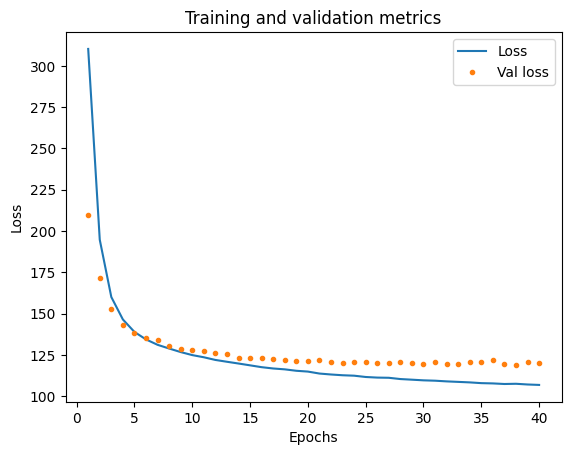

In [27]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, '.', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

## 7) Testing the model

We can now take a look at the performance of our model by _testing_ it on the _test set_:

In [28]:
x_denoised = vae.predict(x_test, batch_size = 32)
x_denoised = np.array(x_denoised)

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-09-27 17:16:50.617162: W tensorflow/c/c_api.cc:305] Operation '{name:'decoder/conv2d_transpose_7/Sigmoid' id:607 op device:{requested: '', assigned: ''} def:{{{node decoder/conv2d_transpose_7/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](decoder/conv2d_transpose_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [29]:
x_denoised.shape

(1032, 28, 28, 1)

### Visual results

Here, we can compare our visual results looking side by side the noisy, targets and denoised  images.

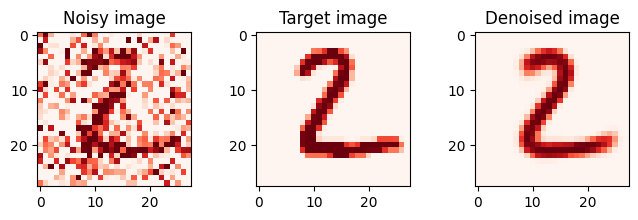

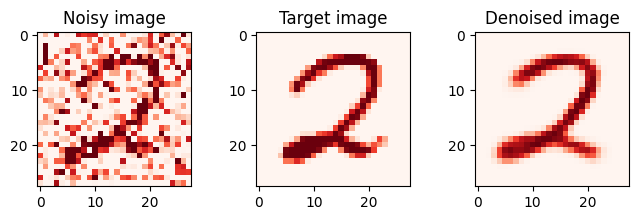

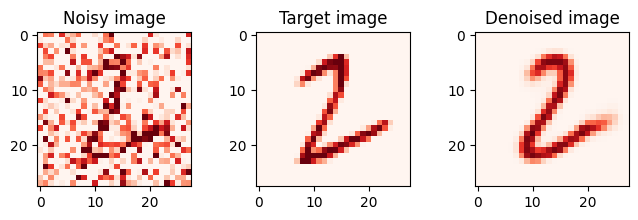

In [35]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(x_denoised[i, :, :, 0].reshape(dimension, dimension), cmap = 'Reds')

Wow, once again we have a good **denoiser**!

But we can get much more from VAE!

## 8) Generating new digits

Because the VAE is a generative model, we can also use it to generate new digits! 

This can be done scanning the latent space, sampling latent points at regular intervals, 

and generating the corresponding digit for each of these points. 

This gives us a visualization of the latent manifold that _generates_ the MNIST digits.

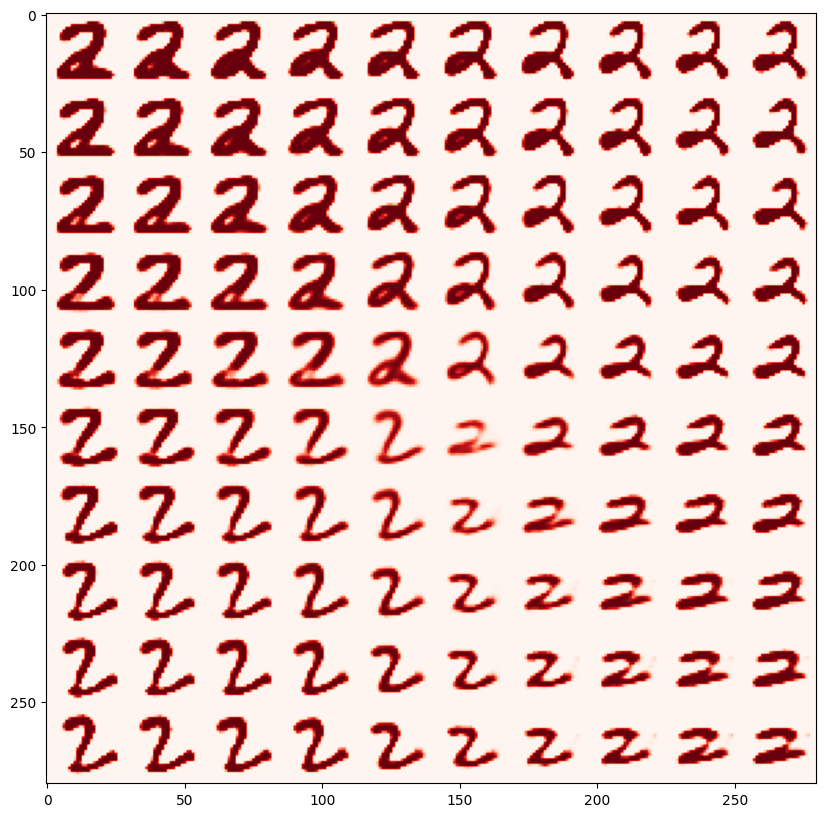

In [40]:
# Display a 2D manifold of the digits
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi, xi, yi, xi, yi, xi, yi, xi, yi, xi, yi, xi, yi, xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize = (10, 10))
plt.imshow(figure, cmap = 'Reds')

And we can see the different ways of writting the digit $2$.

If we have trained the model to denoise all the digits the same would follows!

## References

[1] FAN, L. et al. Brief review of image denoising techniques. Visual Computing for Industry, Biomedicine, and Art, v. 2, 2019.

[2] Tian, C. et al. Deep Learning on Image Denoising: An overview. arXiv e-prints, p. arXiv:1912.13171, dez. 2019.

[3] Chollet, F. [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

[4] de SANTI, N. S. M. Machine learning methods for extracting cosmological information. 2024. doi: [10.11606/T.43.2024.tde-15072024-101341](https://www.teses.usp.br/teses/disponiveis/43/43134/tde-15072024-101341/en.php).

[5] Kingma, D. P. \& Welling, M. 2013, arXiv:1312.6114. doi:10.48550/arXiv.1312.6114